## NYUD-three: semantic segmentation, depth estimation, surface normals estimation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import scipy.misc

In [2]:
import sys
sys.path.append('../')
from models import net

In [3]:
import cv2

In [4]:
import torch
from torch.autograd import Variable

In [5]:
# Pre-processing and post-processing constants #
CMAP = np.load('../cmap_nyud.npy')
DEPTH_COEFF = 5000. # to convert into metres
HAS_CUDA = torch.cuda.is_available()
IMG_SCALE  = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))
MAX_DEPTH = 8.
MIN_DEPTH = 0.
NUM_CLASSES = 40
NUM_TASKS = 3 # segm + depth + normals

In [6]:
def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

In [7]:
model = net(num_classes=NUM_CLASSES, num_tasks=NUM_TASKS)
if HAS_CUDA:
    _ = model.cuda()
_ = model.eval()

In [8]:
ckpt = torch.load('../../weights/ExpNYUD_three.ckpt')
model.load_state_dict(ckpt['state_dict'])

In [10]:
# Figure 5-bottom row
img_path = '/home/tourani/Desktop/code/multi-task-refinenet/src/notebooks/synth.jpg'
img = np.array(Image.open(img_path))
gt_segm = np.array(Image.open('../../examples/ExpNYUD_three/segm_gt_000433.png'))
gt_depth = np.array(Image.open('../../examples/ExpNYUD_three/depth_gt_000433.png'))
gt_norm = np.array(Image.open('../../examples/ExpNYUD_three/norm_gt_000433.png'))

(torch.Size([1, 40, 120, 160]), torch.Size([1, 1, 120, 160]), torch.Size([1, 3, 120, 160]))
('lol', (480, 640))
('haah', (480, 640, 3))
('gasgsa', (480, 640, 3))


/home/tourani/Desktop/code/multi-task-refinenet/multienv/lib/python2.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/tourani/Desktop/code/multi-task-refinenet/multienv/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/tourani/Desktop/code/multi-task-refinenet/multienv/lib/python2.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


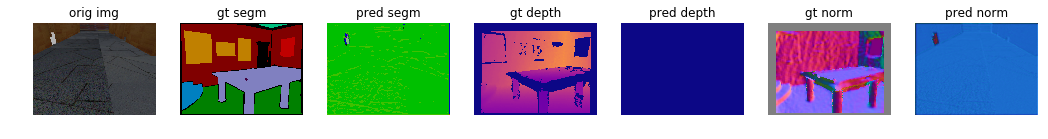

In [11]:
with torch.no_grad():
    img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]), requires_grad=False).float()
    if HAS_CUDA:
        img_var = img_var.cuda()
    segm, depth, norm = model(img_var)
    
    print(segm.shape, depth.shape, norm.shape)
    segm = cv2.resize(segm[0, :NUM_CLASSES].cpu().data.numpy().transpose(1, 2, 0),
                      img.shape[:2][::-1],
                      interpolation=cv2.INTER_CUBIC)
    depth = cv2.resize(depth[0, 0].cpu().data.numpy(),
                       img.shape[:2][::-1],
                       interpolation=cv2.INTER_CUBIC)
    norm = cv2.resize(norm[0].cpu().data.numpy().transpose(1, 2, 0),
                       img.shape[:2][::-1],
                       interpolation=cv2.INTER_CUBIC)
    segm = CMAP[segm.argmax(axis=2) + 1].astype(np.uint8)
    print('lol',depth.shape)
    print('haah', norm.shape)
    depth = np.abs(depth)
    np.save('dep_im.npy', depth)
    out_norm = norm / np.linalg.norm(norm, axis=2, keepdims=True)
    ## xzy->RGB ##
    out_norm[:, :, 0] = ((out_norm[:, :, 0] + 1.) / 2.) * 255.
    out_norm[:, :, 1] = ((out_norm[:, :, 1] + 1.) / 2.) * 255.
    out_norm[:, :, 2] = ((1. - out_norm[:, :, 2]) / 2.) * 255.
    out_norm = out_norm.astype(np.uint8)
    scipy.misc.imsave('outfile.jpg', out_norm)
    scipy.misc.imsave('outfile2.jpg', depth)
    scipy.misc.imsave('outfile3.jpg', segm)
    print('gasgsa', out_norm.shape)

plt.figure(figsize=(18, 12))
plt.subplot(171)
plt.imshow(img)
plt.title('orig img')
plt.axis('off')
plt.subplot(172)
plt.imshow(CMAP[gt_segm + 1])
plt.title('gt segm')
plt.axis('off')
plt.subplot(173)
plt.imshow(segm)
plt.title('pred segm')
plt.axis('off')
plt.subplot(174)
plt.imshow(gt_depth / DEPTH_COEFF, cmap='plasma', vmin=MIN_DEPTH, vmax=MAX_DEPTH)
plt.title('gt depth')
plt.axis('off')
plt.subplot(175)
plt.imshow(depth, cmap='plasma', vmin=MIN_DEPTH, vmax=MAX_DEPTH)
plt.title('pred depth')
plt.axis('off')
plt.subplot(176)
plt.imshow(gt_norm)
plt.title('gt norm')
plt.axis('off')
plt.subplot(177)
plt.imshow(out_norm)
plt.title('pred norm')
plt.axis('off');